In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [177]:
#epw_reader adapted from https://github.com/architecture-building-systems/CEAforArcGIS/blob/master/cea/utilities/epwreader.py
def epw_reader(weather_path):

    epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                       'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2',
                       'dirnorrad_Whm2', 'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux','difhorillum_lux',
                       'zenlum_lux', 'winddir_deg', 'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km',
                       'ceiling_hgt_m', 'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths',
                       'snowdepth_cm', 'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']

    result = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1)
    result['dayofyear'] = pd.date_range('1/1/2010', periods=8760, freq='H').dayofyear  
    result['date'] = pd.date_range('1/1/2010', periods=8760, freq='H')
    result['ratio_diffhout'] = result['difhorrad_Whm2']/result['glohorrad_Whm2']
    return result

#create drybulb temperature table from weather file for a range of days
def get_epw_data(start,end,field = []): 
    weather_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\CH_ZH_original.epw'
    start += ' 00:00:00'
    end += ' 23:00:00'

    series = epw_reader(weather_path=weather_path)  
    series = series.set_index(['date'])

    series = series[start:end][field]

    return series

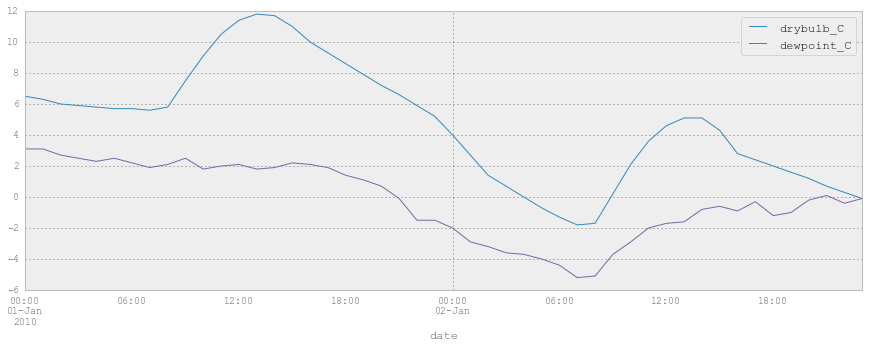

In [178]:
#Simple Plot

start = '1/1/2010'
end = '1/2/2010'
field = ['drybulb_C','dewpoint_C']

t = get_epw_data(start,end,field)
t.plot()

In [ ]:
"""
Input data
Adapted from https://github.com/architecture-building-systems/RC_BuildingSimulator/blob/master/simulator/BuildingProperties.py
"""

class building(object): 
    def __init__(self, 
                 R_env = 42,   #resistance of envelope
                 Cm    = 2.07   #capacitance of envelope
                ):
        #Single Capacitance Model Parameters
        self.Cm=Cm #[kWh/K] Room Capacitance. Default based of Madsen2011
        self.R_env=R_env #[K/kW] Wall resistance to outside air. Default based off glass having a Uvalue of 1.978W/m2K, 12m2 facade glass
        

In [ ]:
class weather
    def __init__(self, 
                 T_out,        #ambient temperature
                 T_in,         #indoor temperature at time m
                 del_t,        #discrete time step
                ):
        self.T_out = T_out
        self.T_in = T_in
        self.del_t = del_t

In [ ]:
"""
main
"""

#import data
T_out = get_epw_data('01/01/2005','12/31/2005',['drybulb_C'])
box = building(Cm = 2.07,R_env = 42)

#initialize conditions
T_in = 20 #starting internal temperature
start = '1/1/2010'
end = '2/1/2010'
duration = len(pd.date_range(start,end))*24

#no heating or cooling, no internal gains, no external gains.

#differential equation parameters
dt = 1

#Forward Euler discretization
for i in range(0,duration):
    for j in range(1,1/dt):
        dT_in = ((T_out-T_in)/(R_env*Cm))*dt + T_in
        T_in += dT_in
        




T_out: External temperature in C extracted from an EPW weather file

T_in: Calculated internal temperature

R_env: Resistance of the envelope. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

R_infl: Equivalent resistance due to infiltration. This is calculated within BuildingProperties.py

R_vent: Equivalent resistance due to ventelation. A variable resistance calculated by the setVentelation method in within the Building class of BuildingProperties.py

Cm: Capacitance of the room. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

Q_Heat: Heat energy supplied or removed by the heater or cooler. This is determined through a controller based on the temperature set points

Q_rad: Heat energy to the sun. Hourly radiation data through the windows must be determined in advance and read through the read_transmittedR funtion of input_data.py

Q_gains: Internal heat gains of people. Determined through the occupancy profile which is read in through the read_occupancy function of input_data.py